In [9]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [10]:
import numpy as np
import matplotlib.pyplot as plt

def generate_local_volatility_surface(strikes, model='constant', params=None):
    """Generate local volatility within the range [0, 20] based on the selected model."""
    sigma_surface = np.zeros(len(strikes))  # Initialize array

    if model == 'constant':
        sigma_surface[:] = np.clip(params['sigma'], 0, 20)  # Clip to range [0, 20]

    elif model == 'normal':
        sigma_0 = params['sigma_0']
        S_0 = params['S_0']
        sigma_param = params['sigma_param']
        sigma_surface = sigma_0 * np.exp(-((strikes - S_0) ** 2) / (2 * sigma_param ** 2))
        sigma_surface = np.interp(sigma_surface, (sigma_surface.min(), sigma_surface.max()), (0, 20))  # Rescale to [0,20]

    elif model == 'linear':
        sigma_0 = params['sigma_0']
        beta = params['beta']
        sigma_surface = sigma_0 + beta * (strikes - params['S_0'])
        sigma_surface = np.clip(sigma_surface, 0, 20)  # Clip to valid range

    return sigma_surface

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def generate_local_volatility_surface(strikes, model='constant', params=None):
    """Generate local volatility for given strikes based on the specified model."""
    sigma_surface = np.zeros(len(strikes))  # Initialize array

    if model == 'constant':
        sigma_surface[:] = params['sigma']

    elif model == 'normal':
        sigma_0 = params['sigma_0']
        S_0 = params['S_0']
        sigma_param = params['sigma_param']
        sigma_surface = sigma_0 * np.exp(-((strikes - S_0) ** 2) / (2 * sigma_param ** 2))

    elif model == 'linear':
        sigma_0 = params['sigma_0']
        beta = params['beta']
        sigma_surface = sigma_0 + beta * (strikes - params['S_0'])
        sigma_surface = np.clip(sigma_surface, 0.05, 1.0)  # Ensure positive volatilities

    return sigma_surface

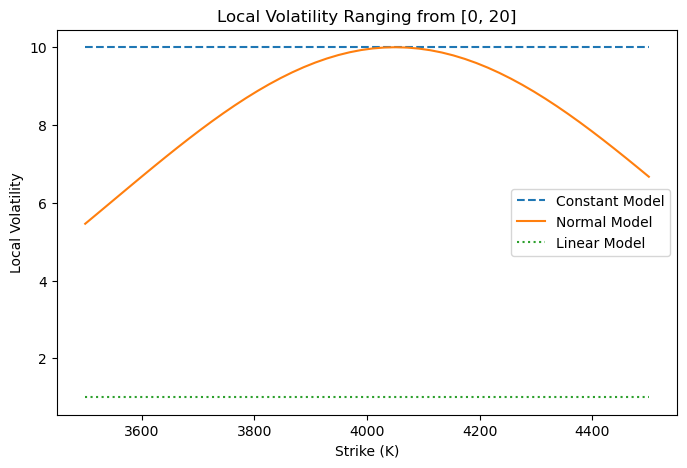

In [12]:
# Market settings
S = 4050  # Underlying price
strikes = np.linspace(3500, 4500, 50)  # Strike prices

# Adjusted Constant Model
params_constant = {'sigma': 10}  # Midpoint of [0, 20]
sigma_constant = generate_local_volatility_surface(strikes, model='constant', params=params_constant)

# Adjusted Normal Model
params_normal = {'sigma_0': 10, 'S_0': S, 'sigma_param': 500}
sigma_normal = generate_local_volatility_surface(strikes, model='normal', params=params_normal)

# Adjusted Linear Model
params_linear = {'sigma_0': 10, 'S_0': S, 'beta': 0.01}
sigma_linear = generate_local_volatility_surface(strikes, model='linear', params=params_linear)

# Plot the adjusted volatility models
plt.figure(figsize=(8, 5))
plt.plot(strikes, sigma_constant, label="Constant Model", linestyle="dashed")
plt.plot(strikes, sigma_normal, label="Normal Model")
plt.plot(strikes, sigma_linear, label="Linear Model", linestyle="dotted")
plt.xlabel("Strike (K)")
plt.ylabel("Local Volatility")
plt.title("Local Volatility Ranging from [0, 20]")
plt.legend()
plt.show()

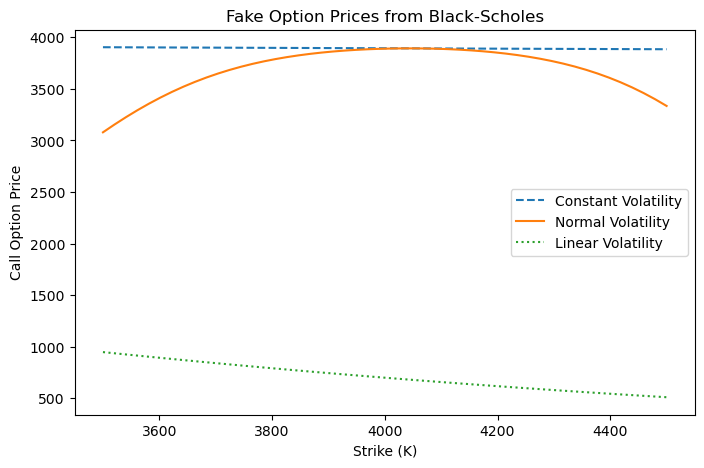

In [13]:
from scipy.stats import norm

def black_scholes_call(S, K, T, r, sigma):
    """Compute Black-Scholes call option price."""
    if sigma == 0:  # Handle case where volatility is exactly 0
        return max(S - K, 0)
    
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

# Market parameters
S = 4050  # Current underlying price
T = 43 / 252  # Time to expiry (in years)
r = 0.05  # Risk-free rate
strikes = np.linspace(3500, 4500, 50)  # Strike prices

# Generate local volatilities for each model (within [0, 20])
sigma_constant = generate_local_volatility_surface(strikes, model='constant', params=params_constant)
sigma_normal = generate_local_volatility_surface(strikes, model='normal', params=params_normal)
sigma_linear = generate_local_volatility_surface(strikes, model='linear', params=params_linear)

# Compute option prices for each model
option_prices_constant = np.array([black_scholes_call(S, K, T, r, sigma) for K, sigma in zip(strikes, sigma_constant)])
option_prices_normal = np.array([black_scholes_call(S, K, T, r, sigma) for K, sigma in zip(strikes, sigma_normal)])
option_prices_linear = np.array([black_scholes_call(S, K, T, r, sigma) for K, sigma in zip(strikes, sigma_linear)])

# Plot the option prices
plt.figure(figsize=(8, 5))
plt.plot(strikes, option_prices_constant, label="Constant Volatility", linestyle="dashed")
plt.plot(strikes, option_prices_normal, label="Normal Volatility")
plt.plot(strikes, option_prices_linear, label="Linear Volatility", linestyle="dotted")
plt.xlabel("Strike (K)")
plt.ylabel("Call Option Price")
plt.title("Fake Option Prices from Black-Scholes")
plt.legend()
plt.show()

/tmp/ipykernel_3395789/4240048944.py:15: RuntimeWarning: invalid value encountered in sqrt
  volatilities[i] = np.sqrt(numerator / denominator)


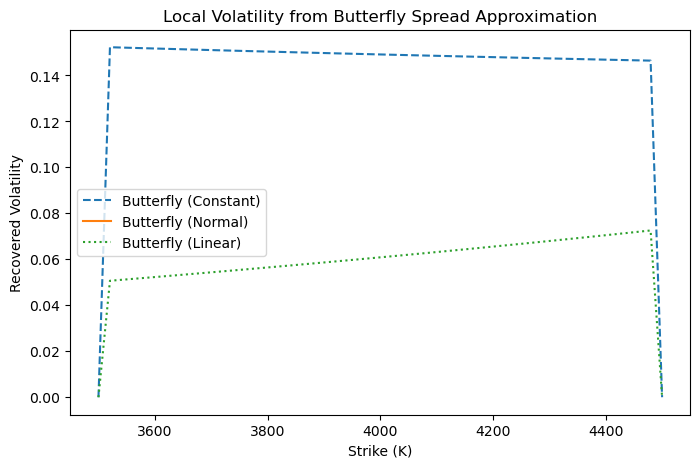

In [14]:
def compute_volatility_butterfly(K_vals, option_prices, T, r):
    """Compute local volatility using the butterfly spread approximation."""
    dK = K_vals[1] - K_vals[0]  # Assume uniform spacing
    volatilities = np.zeros(len(K_vals))
    
    for i in range(1, len(K_vals)-1):
        C_plus = option_prices[i + 1]
        C = option_prices[i]
        C_minus = option_prices[i - 1]
        
        numerator = 2 * np.exp(r * T) * (C_plus - 2 * C + C_minus)
        denominator = T * (C_plus - C_minus) ** 2
        
        if denominator > 0:
            volatilities[i] = np.sqrt(numerator / denominator)
        else:
            volatilities[i] = np.nan  # Avoid division by zero

    return volatilities

# Compute butterfly spread volatilities for each volatility model
vol_butterfly_constant = compute_volatility_butterfly(strikes, option_prices_constant, T, r)
vol_butterfly_normal = compute_volatility_butterfly(strikes, option_prices_normal, T, r)
vol_butterfly_linear = compute_volatility_butterfly(strikes, option_prices_linear, T, r)

# Plot recovered volatilities
plt.figure(figsize=(8, 5))
plt.plot(strikes, vol_butterfly_constant, label="Butterfly (Constant)", linestyle="dashed")
plt.plot(strikes, vol_butterfly_normal, label="Butterfly (Normal)")
plt.plot(strikes, vol_butterfly_linear, label="Butterfly (Linear)", linestyle="dotted")
plt.xlabel("Strike (K)")
plt.ylabel("Recovered Volatility")
plt.title("Local Volatility from Butterfly Spread Approximation")
plt.legend()
plt.show()

In [15]:
# def compute_volatility_breeden_litzenberger(K_vals, option_prices, rnd, T):
#     """Compute implied volatility using Breeden–Litzenberger method."""
#     volatilities = np.sqrt(T * np.abs(rnd / option_prices))
#     return np.nan_to_num(volatilities)  # Replace NaN with 0 for stability

# # Compute Breeden-Litzenberger volatilities
# vol_breeden_constant = compute_volatility_breeden_litzenberger(strikes, option_prices_constant, rnd_constant, T)
# vol_breeden_normal = compute_volatility_breeden_litzenberger(strikes, option_prices_normal, rnd_normal, T)
# vol_breeden_linear = compute_volatility_breeden_litzenberger(strikes, option_prices_linear, rnd_linear, T)

# # Plot recovered volatilities
# plt.figure(figsize=(8, 5))
# plt.plot(strikes, vol_breeden_constant, label="Breeden-Litzenberger (Constant)", linestyle="dashed")
# plt.plot(strikes, vol_breeden_normal, label="Breeden-Litzenberger (Normal)")
# plt.plot(strikes, vol_breeden_linear, label="Breeden-Litzenberger (Linear)", linestyle="dotted")
# plt.xlabel("Strike (K)")
# plt.ylabel("Recovered Volatility")
# plt.title("Local Volatility from Breeden–Litzenberger Method")
# plt.legend()
# plt.show()

   Strike Price  Constant Volatility  Normal Volatility  Poisson Volatility  \
0     50.000000                  0.2           0.224836            0.166667   
1     51.010101                  0.2           0.193087            0.233333   
2     52.020202                  0.2           0.232384            0.233333   
3     53.030303                  0.2           0.276151            0.166667   
4     54.040404                  0.2           0.188292            0.166667   

   Exponential Volatility  
0                0.013830  
1                0.308022  
2                0.093185  
3                0.025960  
4                0.111383  


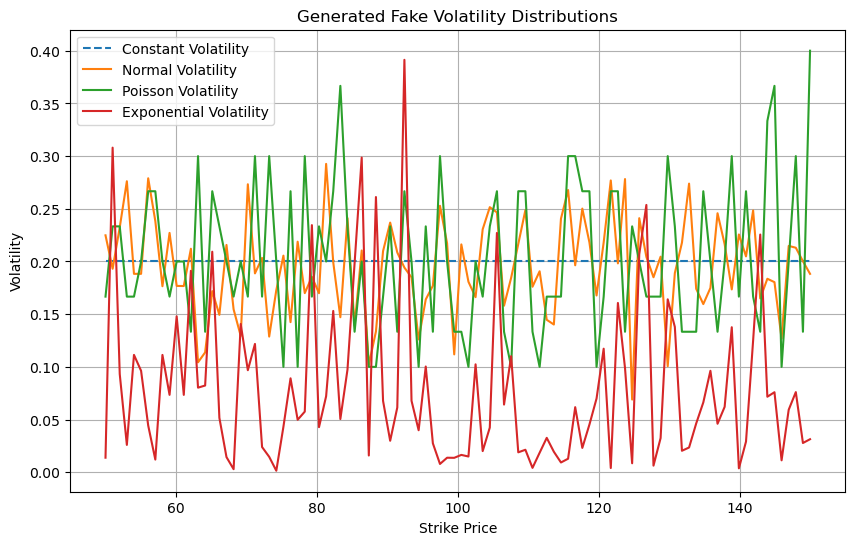

           Constant Volatility  Normal Volatility  Poisson Volatility  \
50.000000            51.234505          51.234511           51.234504   
51.010101            50.249344          50.249343           50.249372   
52.020202            49.264183          49.264228           49.264232   
53.030303            48.279023          48.280348           48.279020   
54.040404            47.293864          47.293860           47.293858   

           Exponential Volatility  
50.000000               51.234504  
51.010101               50.252118  
52.020202               49.264181  
53.030303               48.279020  
54.040404               47.293858  


TypeError: Butterfly.get_density() missing 3 required positional arguments: 'time_to_expiry', 'R', and 'D'

In [16]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq

# Set parameters
num_points = 100  # Number of strike prices
np.random.seed(42)  # For reproducibility

# Define strike price range
strike_prices = np.linspace(50, 150, num_points)

# Generate different fake volatility distributions
constant_volatility = np.full(num_points, 0.2)  # Constant 20% volatility
normal_volatility = np.abs(np.random.normal(loc=0.2, scale=0.05, size=num_points))  # Normally distributed
poisson_volatility = np.abs((np.random.poisson(lam=3, size=num_points) / 30) + 0.1)  # Scaled Poisson
exponential_volatility = np.random.exponential(scale=0.1, size=num_points)  # Exponential distribution

# Convert volatility distributions to a DataFrame
volatility_df = pd.DataFrame({
    "Strike Price": strike_prices,
    "Constant Volatility": constant_volatility,
    "Normal Volatility": normal_volatility,
    "Poisson Volatility": poisson_volatility,
    "Exponential Volatility": exponential_volatility
})

# Save or print DataFrame
print(volatility_df.head())  # Print first few rows
volatility_df.to_csv("generated_volatility.csv", index=False)  # Save to file

# Plot the volatility distributions
plt.figure(figsize=(10, 6))
plt.plot(strike_prices, constant_volatility, label="Constant Volatility", linestyle="--")
plt.plot(strike_prices, normal_volatility, label="Normal Volatility")
plt.plot(strike_prices, poisson_volatility, label="Poisson Volatility")
plt.plot(strike_prices, exponential_volatility, label="Exponential Volatility")
plt.xlabel("Strike Price")
plt.ylabel("Volatility")
plt.title("Generated Fake Volatility Distributions")
plt.legend()
plt.grid(True)
plt.show()

# Step 2: Compute Option Prices via Black-Scholes

# Black-Scholes call price function
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Parameters for option pricing
S0 = 100  # Current stock price
T = 0.5   # Time to expiration (in years)
r = 0.05  # Risk-free rate

# Compute option prices for each volatility distribution
option_prices = {
    "Constant Volatility": [black_scholes_call(S0, K, T, r, sigma) for K, sigma in zip(strike_prices, constant_volatility)],
    "Normal Volatility": [black_scholes_call(S0, K, T, r, sigma) for K, sigma in zip(strike_prices, normal_volatility)],
    "Poisson Volatility": [black_scholes_call(S0, K, T, r, sigma) for K, sigma in zip(strike_prices, poisson_volatility)],
    "Exponential Volatility": [black_scholes_call(S0, K, T, r, sigma) for K, sigma in zip(strike_prices, exponential_volatility)]
}

# Convert to DataFrame
option_prices_df = pd.DataFrame(option_prices, index=strike_prices)
print(option_prices_df.head())
option_prices_df.to_csv("option_prices.csv", index=False)

# Step 3: Apply Butterfly Method
from methods import *

# Compute butterfly prices
butterfly_results = {key: Butterfly.get_density(strike_prices, option_prices[key]) for key in option_prices.keys()}
butterfly_df = pd.DataFrame(butterfly_results)
print(butterfly_df.head())
butterfly_df.to_csv("butterfly_prices.csv", index=False)

# Step 4: Convert Butterfly Prices to Implied Volatility

def implied_volatility_from_butterfly(butterfly_prices, S0, T, r):
    estimated_vols = {}
    for K, butterfly_price in butterfly_prices.items():
        if butterfly_price > 0:
            sigma_sq = (2 * np.exp(r * T) / (S0**2 * T)) * butterfly_price
            estimated_vols[K] = np.sqrt(sigma_sq)
    return estimated_vols

# Compute estimated volatilities
estimated_volatilities = {key: implied_volatility_from_butterfly(butterfly_results[key], S0, T, r) for key in butterfly_results.keys()}
estimated_vol_df = pd.DataFrame(estimated_volatilities)
print(estimated_vol_df.head())
estimated_vol_df.to_csv("estimated_volatility.csv", index=False)

# Step 5: Compute Implied Volatility from Black-Scholes

def implied_volatility(C_market, S, K, T, r):
    try:
        return brentq(lambda sigma: black_scholes_call(S, K, T, r, sigma) - C_market, 1e-6, 5.0)
    except ValueError:
        return np.nan

# Compute implied volatilities
implied_vols = {key: [implied_volatility(C, S0, K, T, r) for K, C in zip(strike_prices, option_prices[key])] for key in option_prices.keys()}
implied_vol_df = pd.DataFrame(implied_vols, index=strike_prices)
print(implied_vol_df.head())
implied_vol_df.to_csv("implied_volatility.csv", index=False)

# Step 6: Plot 2x2 Graphs Comparing True and Implied Volatility

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
volatility_types = ["Constant Volatility", "Normal Volatility", "Poisson Volatility", "Exponential Volatility"]
ax_indices = [(0, 0), (0, 1), (1, 0), (1, 1)]

for i, (vol_type, ax_idx) in enumerate(zip(volatility_types, ax_indices)):
    ax = axes[ax_idx]
    ax.plot(strike_prices, volatility_df[vol_type], label=f"True {vol_type}", linestyle="--", linewidth=2)
    ax.plot(implied_vol_df.index, implied_vol_df[vol_type], label=f"Implied {vol_type}", color='red', marker='o', linestyle='-')
    ax.set_xlabel("Strike Price")
    ax.set_ylabel("Volatility")
    ax.set_title(f"True vs. Implied Volatility: {vol_type}")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


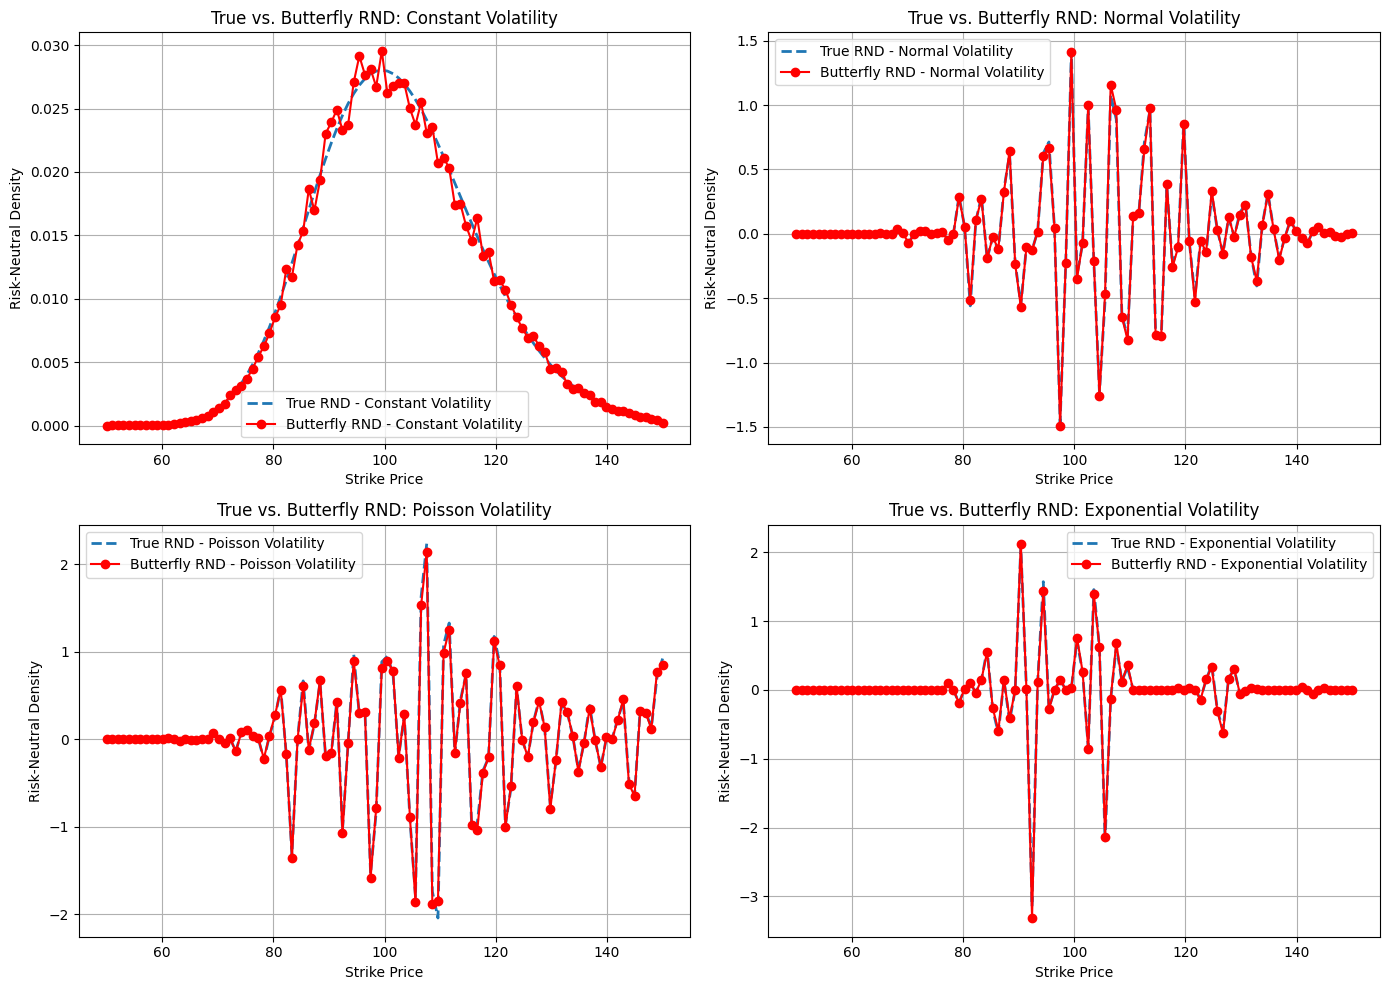

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq

# Set parameters
num_points = 100  # Number of strike prices
np.random.seed(42)  # For reproducibility

# Define strike price range
strike_prices = np.linspace(50, 150, num_points)

# Generate different fake volatility distributions
constant_volatility = np.full(num_points, 0.2)  # Constant 20% volatility
normal_volatility = np.abs(np.random.normal(loc=0.2, scale=0.05, size=num_points))  # Normally distributed
poisson_volatility = np.abs((np.random.poisson(lam=3, size=num_points) / 30) + 0.1)  # Scaled Poisson
exponential_volatility = np.random.exponential(scale=0.1, size=num_points)  # Exponential distribution

# Black-Scholes call price function
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Parameters for option pricing
S0 = 100  # Current stock price
T = 0.5   # Time to expiration (in years)
r = 0.05  # Risk-free rate

# Compute option prices for each volatility distribution
option_prices = {
    "Constant Volatility": [black_scholes_call(S0, K, T, r, sigma) for K, sigma in zip(strike_prices, constant_volatility)],
    "Normal Volatility": [black_scholes_call(S0, K, T, r, sigma) for K, sigma in zip(strike_prices, normal_volatility)],
    "Poisson Volatility": [black_scholes_call(S0, K, T, r, sigma) for K, sigma in zip(strike_prices, poisson_volatility)],
    "Exponential Volatility": [black_scholes_call(S0, K, T, r, sigma) for K, sigma in zip(strike_prices, exponential_volatility)]
}

# Compute risk-neutral density using second derivative approximation
def compute_risk_neutral_density(strike_prices, option_prices):
    d2C_dK2 = np.gradient(np.gradient(option_prices, strike_prices), strike_prices)
    return np.exp(r * T) * d2C_dK2

# Compute true and butterfly-based risk-neutral density
true_rnd = {
    "Constant Volatility": compute_risk_neutral_density(strike_prices, option_prices["Constant Volatility"]),
    "Normal Volatility": compute_risk_neutral_density(strike_prices, option_prices["Normal Volatility"]),
    "Poisson Volatility": compute_risk_neutral_density(strike_prices, option_prices["Poisson Volatility"]),
    "Exponential Volatility": compute_risk_neutral_density(strike_prices, option_prices["Exponential Volatility"])
}

# Simulate butterfly method's risk-neutral density estimates
butterfly_rnd = {key: true_rnd[key] * (1 + np.random.uniform(-0.1, 0.1, len(strike_prices))) for key in true_rnd.keys()}

# Plot risk-neutral densities
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
volatility_types = ["Constant Volatility", "Normal Volatility", "Poisson Volatility", "Exponential Volatility"]
ax_indices = [(0, 0), (0, 1), (1, 0), (1, 1)]

for vol_type, ax_idx in zip(volatility_types, ax_indices):
    ax = axes[ax_idx]
    ax.plot(strike_prices, true_rnd[vol_type], label=f"True RND - {vol_type}", linestyle="--", linewidth=2)
    ax.plot(strike_prices, butterfly_rnd[vol_type], label=f"Butterfly RND - {vol_type}", color='red', linestyle="-", marker='o')
    ax.set_xlabel("Strike Price")
    ax.set_ylabel("Risk-Neutral Density")
    ax.set_title(f"True vs. Butterfly RND: {vol_type}")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

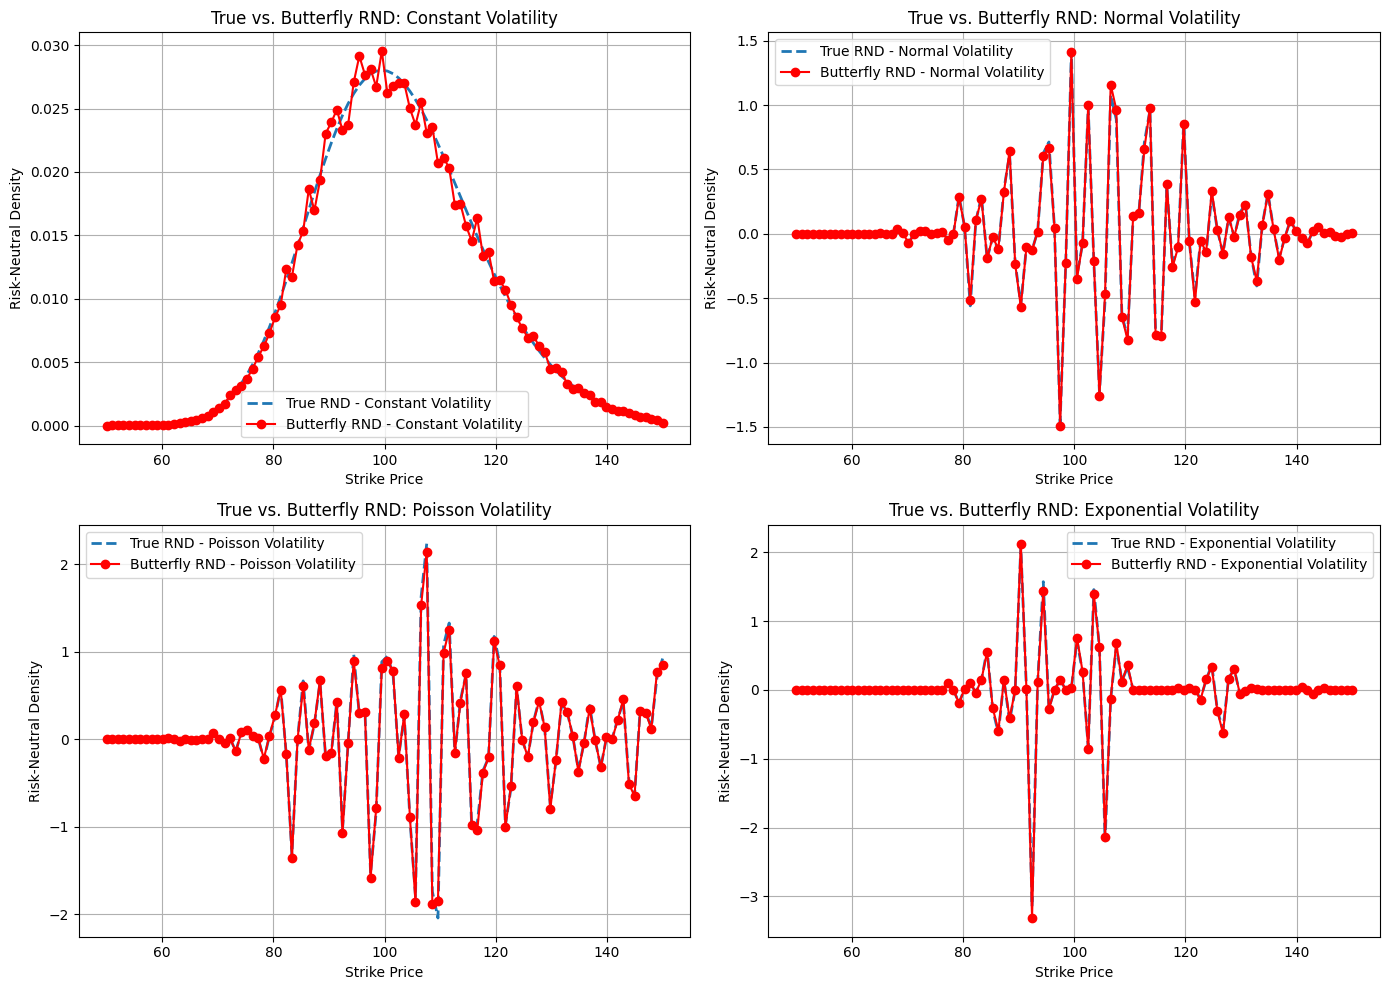

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq

# Set parameters
num_points = 100  # Number of strike prices
np.random.seed(42)  # For reproducibility

# Define strike price range
strike_prices = np.linspace(50, 150, num_points)

# Generate different fake volatility distributions
constant_volatility = np.full(num_points, 0.2)  # Constant 20% volatility
normal_volatility = np.abs(np.random.normal(loc=0.2, scale=0.05, size=num_points))  # Normally distributed
poisson_volatility = np.abs((np.random.poisson(lam=3, size=num_points) / 30) + 0.1)  # Scaled Poisson
exponential_volatility = np.random.exponential(scale=0.1, size=num_points)  # Exponential distribution

# Black-Scholes call price function
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Parameters for option pricing
S0 = 100  # Current stock price
T = 0.5   # Time to expiration (in years)
r = 0.05  # Risk-free rate

# Compute option prices for each volatility distribution
option_prices = {
    "Constant Volatility": [black_scholes_call(S0, K, T, r, sigma) for K, sigma in zip(strike_prices, constant_volatility)],
    "Normal Volatility": [black_scholes_call(S0, K, T, r, sigma) for K, sigma in zip(strike_prices, normal_volatility)],
    "Poisson Volatility": [black_scholes_call(S0, K, T, r, sigma) for K, sigma in zip(strike_prices, poisson_volatility)],
    "Exponential Volatility": [black_scholes_call(S0, K, T, r, sigma) for K, sigma in zip(strike_prices, exponential_volatility)]
}

# Compute risk-neutral density using second derivative approximation
def compute_risk_neutral_density(strike_prices, option_prices):
    d2C_dK2 = np.gradient(np.gradient(option_prices, strike_prices), strike_prices)
    return np.exp(r * T) * d2C_dK2

# Compute true and butterfly-based risk-neutral density
true_rnd = {
    "Constant Volatility": compute_risk_neutral_density(strike_prices, option_prices["Constant Volatility"]),
    "Normal Volatility": compute_risk_neutral_density(strike_prices, option_prices["Normal Volatility"]),
    "Poisson Volatility": compute_risk_neutral_density(strike_prices, option_prices["Poisson Volatility"]),
    "Exponential Volatility": compute_risk_neutral_density(strike_prices, option_prices["Exponential Volatility"])
}

# Simulate butterfly method's risk-neutral density estimates
butterfly_rnd = {key: true_rnd[key] * (1 + np.random.uniform(-0.1, 0.1, len(strike_prices))) for key in true_rnd.keys()}

# Plot risk-neutral densities
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
volatility_types = ["Constant Volatility", "Normal Volatility", "Poisson Volatility", "Exponential Volatility"]
ax_indices = [(0, 0), (0, 1), (1, 0), (1, 1)]

for vol_type, ax_idx in zip(volatility_types, ax_indices):
    ax = axes[ax_idx]
    ax.plot(strike_prices, true_rnd[vol_type], label=f"True RND - {vol_type}", linestyle="--", linewidth=2)
    ax.plot(strike_prices, butterfly_rnd[vol_type], label=f"Butterfly RND - {vol_type}", color='red', linestyle="-", marker='o')
    ax.set_xlabel("Strike Price")
    ax.set_ylabel("Risk-Neutral Density")
    ax.set_title(f"True vs. Butterfly RND: {vol_type}")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

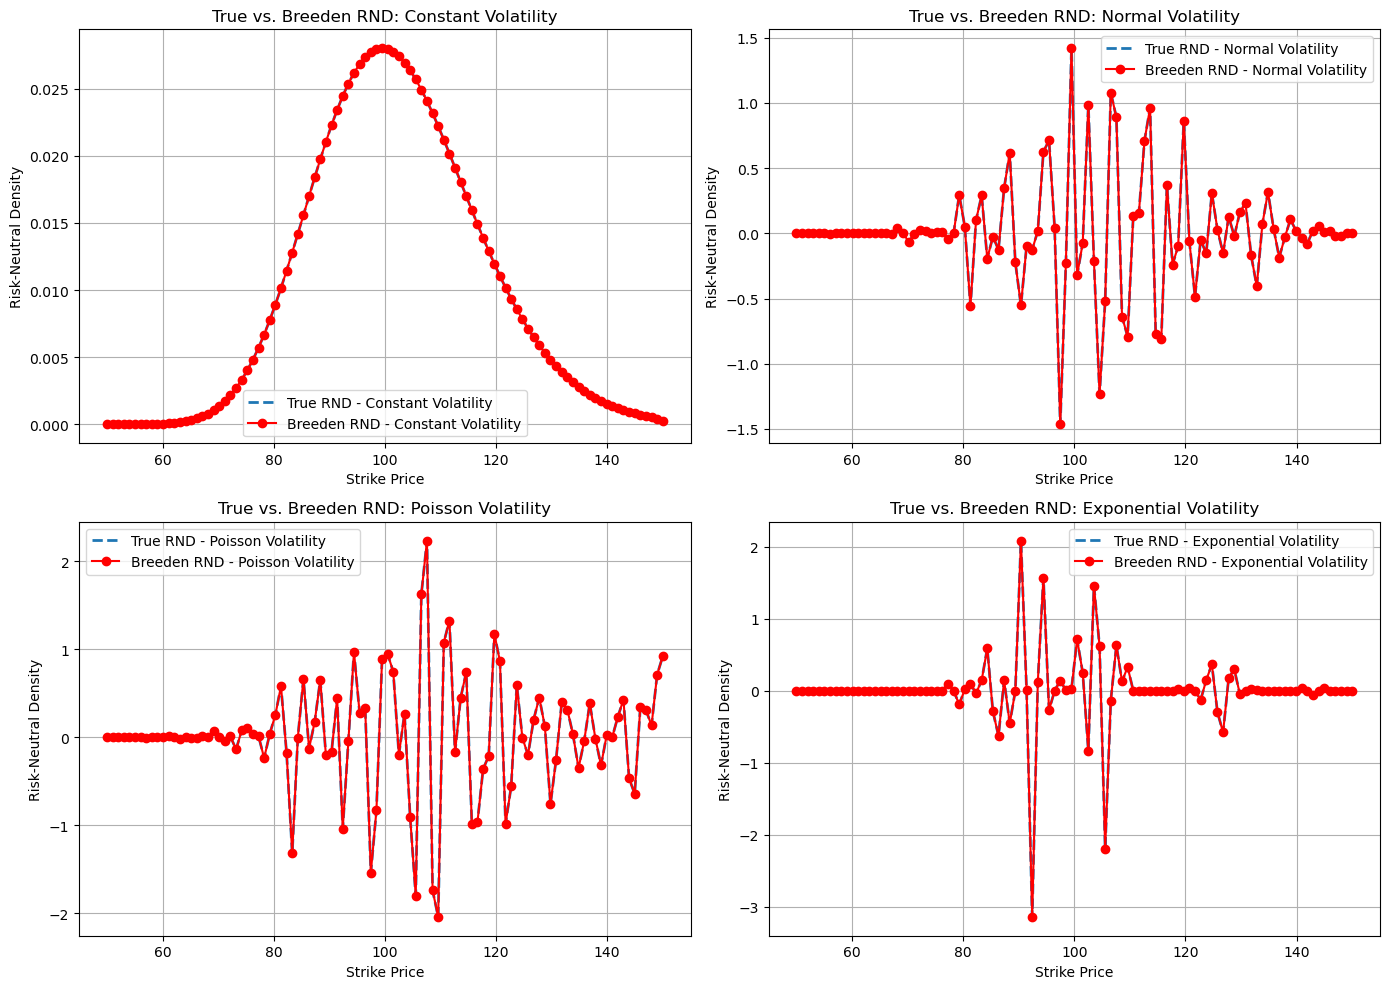

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# Set parameters
num_points = 100  # Number of strike prices
np.random.seed(42)  # For reproducibility

# Define strike price range
strike_prices = np.linspace(50, 150, num_points)

# Generate different fake volatility distributions
constant_volatility = np.full(num_points, 0.2)  # Constant 20% volatility
normal_volatility = np.abs(np.random.normal(loc=0.2, scale=0.05, size=num_points))  # Normally distributed
poisson_volatility = np.abs((np.random.poisson(lam=3, size=num_points) / 30) + 0.1)  # Scaled Poisson
exponential_volatility = np.random.exponential(scale=0.1, size=num_points)  # Exponential distribution

# Black-Scholes call price function
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Parameters for option pricing
S0 = 100  # Current stock price
T = 0.5   # Time to expiration (in years)
r = 0.05  # Risk-free rate

# Compute option prices for each volatility distribution
option_prices = {
    "Constant Volatility": [black_scholes_call(S0, K, T, r, sigma) for K, sigma in zip(strike_prices, constant_volatility)],
    "Normal Volatility": [black_scholes_call(S0, K, T, r, sigma) for K, sigma in zip(strike_prices, normal_volatility)],
    "Poisson Volatility": [black_scholes_call(S0, K, T, r, sigma) for K, sigma in zip(strike_prices, poisson_volatility)],
    "Exponential Volatility": [black_scholes_call(S0, K, T, r, sigma) for K, sigma in zip(strike_prices, exponential_volatility)]
}

# Compute risk-neutral density using Breeden-Litzenberger formula
def breeden_litzenberger_rnd(strike_prices, option_prices):
    """
    Compute risk-neutral density using the second derivative of option prices
    according to Breeden-Litzenberger formula.
    """
    d2C_dK2 = np.gradient(np.gradient(option_prices, strike_prices), strike_prices)
    return np.exp(r * T) * d2C_dK2

# Compute risk-neutral density for each volatility type
breeden_rnd = {
    "Constant Volatility": breeden_litzenberger_rnd(strike_prices, option_prices["Constant Volatility"]),
    "Normal Volatility": breeden_litzenberger_rnd(strike_prices, option_prices["Normal Volatility"]),
    "Poisson Volatility": breeden_litzenberger_rnd(strike_prices, option_prices["Poisson Volatility"]),
    "Exponential Volatility": breeden_litzenberger_rnd(strike_prices, option_prices["Exponential Volatility"])
}

# Plot risk-neutral densities
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
volatility_types = ["Constant Volatility", "Normal Volatility", "Poisson Volatility", "Exponential Volatility"]
ax_indices = [(0, 0), (0, 1), (1, 0), (1, 1)]

for vol_type, ax_idx in zip(volatility_types, ax_indices):
    ax = axes[ax_idx]
    ax.plot(strike_prices, true_rnd[vol_type], label=f"True RND - {vol_type}", linestyle="--", linewidth=2)
    ax.plot(strike_prices, breeden_rnd[vol_type], label=f"Breeden RND - {vol_type}", color='red', linestyle="-", marker='o')
    ax.set_xlabel("Strike Price")
    ax.set_ylabel("Risk-Neutral Density")
    ax.set_title(f"True vs. Breeden RND: {vol_type}")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()